# Ordinary Differential Equation Solvers
## Christina Lee

So what's an <i>Ordinary Differential Equation</i>?

Differential Equation means we have some equation (or equations) that have derivatives in them.  

The <i>ordinary</i> part differentiates them from <i>partial</i> differential equations (the ones with curly $\partial$ derivatives).  Here, we only have one <b>independent</b> variable (let's call it $t$), and one or more <b>dependent</b>  variables (let's call them $x_1, x_2, ...$).  In partial differential equations, we can have more than one independent variable.

This ODE can either be written as a system of the form
$$
\frac{d x_1}{dt}=f_1(t,x_1,x_2,...,x_n)
$$
$$
\frac{d x_2}{dt}=f_2(t,x_1,x_2,...,x_n)
$$
...
$$
\frac{d x_n}{dt}=f_n(t,x_1,x_n,...,x_n)
$$
or a single n'th order ODE of the form
$$
f_n(t,x) \frac{d^n x}{dt^n}+...+f_1(t,x) \frac{dx}{dt}+f_0(t,x)=0
$$
that can be rewritten in terms of a system of first order equations by performing variable substitutions such as
$$
\frac{d^i x}{dt^i}=x_i
$$

Though STEM students such as I have probably spent thousands of hours pouring of ways to analytically solve both ordinary and partial differential equations, unfortunately the real world is rarely so kind as to provide us with an exactly solvable differential equation.  At least for interesting problems.  

We can sometimes approximate the real world as an exactly solvable situation, but for the situation we are really interested in, we have to turn to numerics.  This isn't saying those thousand different analytic methods are for nothing.  We need an idea ahead of time of what the differential equation should be doing, in order to tell if it's misbehaving or not.  We can't just blindly plug and chug.  

Today will be about introducing four different methods based on Taylor expansion to a specific order, also known as Runge-Kutta Methods.  We can improve these methods with adaptive stepsize control, but that is a topic for another time, just like the other modern types of solvers such as Richardson extrapolation and predictor-corrector.  

Nonetheless, in order to work with ANY computational differential equation solver, you need to understand the fundementals of routines like Euler and Runge Kutta, their error propogation, and where they can go wrong. Otherwise, you might misinterpret the results of more advanced routines. 

<b>WARNING:</b> If you actually need to solve a troublesome differential equation for a research problem, use a package, like [DifferentialEquations](https://github.com/JuliaDiffEq/DifferentialEquations.jl).  These packages have much better error handling and optimization.

Lets first add our plotting package and colors.

In [1]:
using Gadfly
# Solarized Colors that I like working with
# http://ethanschoonover.com/solarized
using Colors
base03=parse(Colorant,"#002b36");
base02=parse(Colorant,"#073642");
base01=parse(Colorant,"#586e75");
base00=parse(Colorant,"#657b83");
base0=parse(Colorant,"#839496");
base1=parse(Colorant,"#839496");
base2=parse(Colorant,"#eee8d5");
base3=parse(Colorant,"#fdf6e3");

yellow=parse(Colorant,"#b58900");
orange=parse(Colorant,"#cb4b16");
red=parse(Colorant,"#dc322f");
magenta=parse(Colorant,"#d33682");
violet=parse(Colorant,"#6c71c4");
blue=parse(Colorant,"#268bd2");
cyan=parse(Colorant,"#3aa198");
green=parse(Colorant,"#859900");



    +(AbstractArray, DataArrays.DataArray) at /Users/mira/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/mira/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /Users/mira/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/mira/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


We will be benchmarking our solvers on one of the simplest and most common ODE's,

\begin{equation}
\frac{d}{d t}x=x \;\;\;\;\;\;\; x(t)=C e^t
\end{equation}

Though this only has one dependent variable, we want to structure our code so that we can accomidate a series of dependent variables, $y_1,y_2,...,y_n$, and their associated derivate functions.  Therefore, we create a function for each dependent variable, and then `push` it into an array that has been declared as type `Function`.

In [2]:
function f1(t::Float64,x::Array{Float64,1})
    return x[1]
end
f=Function[]
push!(f,f1)

1-element Array{Function,1}:
 f1

### Euler's Method
<img src="images/ode/graphic.png" width="400px" style="float: left; margin: 20px"/> 
First published in Euler's <i>Instutionum calculi integralis</i> in 1768, this method gets a lot of milage, and if you are to understand anything, this method is it.  

We march along with stepsize $h$, and at each new point, calculate the slope.  This gives us our new direction to march for the next $h$.

We can determine the error from the Taylor expansion of the function
$$
y_{n+1}=y_n+h f(y_n,t) + \mathcal{O}(h^2).
$$
In case you haven't seen it before, the notation $\mathcal{O}(x)$ stands for "errors of the order x".
Summing over the entire interval, we accumuluate error according to 
$$N\mathcal{O}(h^2)= \frac{y_f-y_0}{h}\mathcal{O}(h^2)=h $$,
making this a <b>first order</b> method.

In [3]:
function Euler(f::Array{Function,1},t0::Float64,x::Array{Float64,1},h::Float64)
    d=length(f)
    xp=copy(x)
    for ii in 1:d
        xp[ii]+=h*f[ii](t0,x)
    end
    
    return t0+h,xp
end

Euler (generic function with 1 method)

## Implicit Method or Backward Euler

\begin{equation}
x_{k+1}+\delta t f(t_{k+1},x_{k+1})= x_k
\end{equation}

If $f(t,x)$ has a form that is invertible, we can form a specific expression for the next step.  For example, if we use our exponential,

\begin{equation}
x_{k+1}+\delta tx_{k+1}=x_k
\end{equation}
\begin{equation}
x_{k+1}=\frac{x_k}{1+\delta t}
\end{equation}

In [4]:
function Implicit(f::Array{Function,1},t0::Float64,x::Array{Float64,1},h::Float64)
    return t0+h,x[1]/(1-h)
end

Implicit (generic function with 1 method)

## 2nd Order Runge-Kutta

So in the Euler Method, we could just make more, tinier steps to achieve more precise results. Here, we make <i>bettter</i> steps.  Each step itself takes more work, but we win by having to perform fewer steps.

This time, we are going to work with the Taylor expansion up to second order,
\begin{equation}
y_{n+1}=y_n+h f(y_n,x_n) + \frac{h^2}{2} f^{\prime}(y_n,x_n)+ \mathcal{O} (h^3).
\end{equation}

Define
\begin{equation}
k_1=f(x_n,y_n),
\end{equation}
so that we can write down the derivative of our $f$ function, and the second derivative (curvature), of our solution,
\begin{equation}
f^{\prime}(x_n,y_n)=\frac{f(x_n+h/2,y_n+k_1/2)-k_1}{h/2}+\mathcal{O}(h^2).
\end{equation}
Plugging this expression back into our Taylor expanion, we get a new expression for $y_{n+1}$
\begin{equation}
y_{n+1}=y_n+hf(x_n+h/2,y_n+k_1/2)+\mathcal{O}(h^3)
\end{equation}

We can also interpret this method as using the slope at the center of the interval instead of the beginning.  

In [5]:
function RK2(f::Array{Function,1},t0::Float64,x::Array{Float64,1},h::Float64)
    d=length(f)
    
    xp=copy(x)
    xk1=copy(x)
    
    for ii in 1:d
        xk1[ii]+=f[ii](t0,x)*h/2
    end
    for ii in 1:d
        xp[ii]+=f[ii](t0+h/2,xk1)*h 
    end
    
    return t0+h,xp
end

RK2 (generic function with 1 method)

In [6]:
function RK4(f::Array{Function,1},t0::Float64,x::Array{Float64,1},h::Float64)
    d=length(f)
    
    k1=zeros(x)
    k2=zeros(x)
    k3=zeros(x)
    k4=zeros(x)
    
    for ii in 1:d
        k1[ii]=h*f[ii](t0,x)
    end
    for ii in 1:d
        k2[ii]=h*f[ii](t0+h/2,x+k1/2)
    end
    for ii in 1:d
        k3[ii]=h*f[ii](t0+h/2,x+k2/2) 
    end
    for ii in 1:d
        k4[ii]=h*f[ii](t0+h,x+k3)
    end
    
    return t0+h,x+(k1+2*k2+2*k3+k4)/6
end

RK4 (generic function with 1 method)

In [ ]:
RK4(f,0.,[1.],.1), exp(.1)

In [7]:
function Solver(f::Array{Function,1},Method::Function,t0::Float64,
        x0::Array{Float64,1},h::Float64,N::Int64)
    d=length(f)
    ts=zeros(Float64,N+1)
    xs=zeros(Float64,d,N+1)
    
    ts[1]=t0
    xs[:,1]=x0
    
    for i in 2:(N+1)
        ts[i],xs[:,i]=Method(f,ts[i-1],xs[:,i-1],h)
    end
    
    return ts,xs
end

Solver (generic function with 1 method)

In [8]:
N=1000
xf=10
t0=0.
x0=[1.]
dt=(xf-t0)/N

tEU,xEU=Solver(f,Euler,t0,x0,dt,N);
tIm,xIm=Solver(f,Implicit,t0,x0,dt,N);
tRK2,xRK2=Solver(f,RK2,t0,x0,dt,N);
tRK4,xRK4=Solver(f,RK4,t0,x0,dt,N);

xi=tEU
yi=exp(xi);

errEU=reshape(xEU[1,:],N+1)-yi
errIm=reshape(xIm[1,:],N+1)-yi
errRK2=reshape(xRK2[1,:],N+1)-yi;
errRK4=reshape(xRK4[1,:],N+1)-yi;

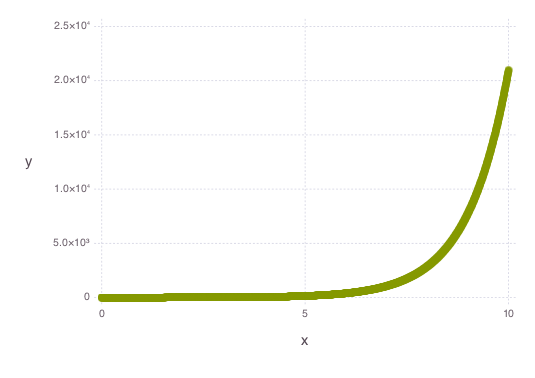

In [9]:
plot(x=tEU,y=xEU[1,:],Geom.point,
Theme(highlight_width=0pt,default_color=green,
default_point_size=3pt))

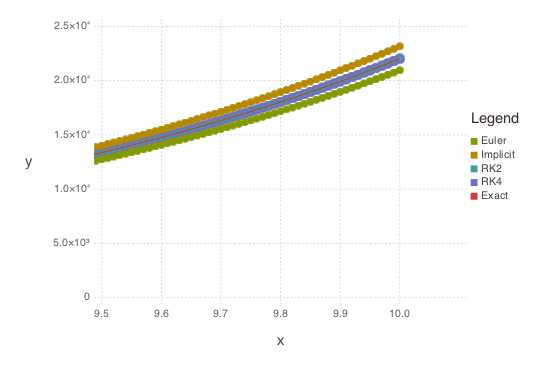

In [11]:
lEU=layer(x=tEU,y=xEU[1,:],Geom.point,
Theme(highlight_width=0pt,default_color=green,
default_point_size=3pt))

lIm=layer(x=tIm,y=xIm[1,:],Geom.point,
Theme(highlight_width=0pt,default_color=yellow,
default_point_size=3pt))

lRK2=layer(x=tRK2,y=xRK2[1,:],Geom.point,
Theme(highlight_width=0pt,default_color=cyan,
default_point_size=2pt))

lRK4=layer(x=tRK4,y=xRK4[1,:],Geom.point,
Theme(highlight_width=0pt,default_color=violet,
default_point_size=4pt))

lp=layer(x->e^x,-.1,10,Geom.line,Theme(default_color=red))


plot(lp,lEU,lIm,lRK2,lRK4,
Guide.manual_color_key("Legend",["Euler","Implicit","RK2","RK4","Exact"],
[green,yellow,cyan,violet,red]),
Coord.cartesian(xmin=9.5,xmax=10.1))

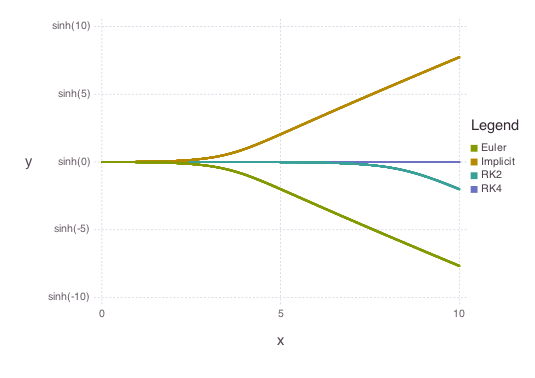

In [12]:
lEU=layer(x=xi,y=errEU,Geom.point,
Theme(highlight_width=0pt,default_color=green,
default_point_size=1pt))

lIm=layer(x=xi,y=errIm,Geom.point,
Theme(highlight_width=0pt,default_color=yellow,
default_point_size=1pt))

lRK2=layer(x=xi,y=errRK2,Geom.point,
Theme(highlight_width=0pt,default_color=cyan,
default_point_size=1pt))

lRK4=layer(x=xi,y=errRK4,Geom.point,
Theme(highlight_width=0pt,default_color=violet,
default_point_size=1pt))

plot(lEU,lIm,lRK2,lRK4,Scale.y_asinh,
Guide.manual_color_key("Legend",["Euler","Implicit","RK2","RK4"],
[green,yellow,cyan,violet]))

In [20]:
t0=0.
tf=1.
dx=tf-t0
x0=[1.]

dt=collect(.001:.0001:.01)

correctans=exp(tf)
errfEU=zeros(dt)
errfIm=zeros(dt)
errfRK2=zeros(dt)
errfRK4=zeros(dt)



for ii in 1:length(dt)
    N=round(Int,dx/dt[ii])
    dt[ii]=dx/N
    
    tEU,xEU=Solver(f,Euler,t0,x0,dt[ii],N);
    tIm,xIm=Solver(f,Implicit,t0,x0,dt[ii],N);
    tRK2,xRK2=Solver(f,RK2,t0,x0,dt[ii],N);
    tRK4,xRK4=Solver(f,RK4,t0,x0,dt[ii],N);
    
    errfEU[ii]=xEU[1,end]-correctans
    errfIm[ii]=xIm[1,end]-correctans
    errfRK2[ii]=xRK2[1,end]-correctans
    errfRK4[ii]=xRK4[1,end]-correctans
end

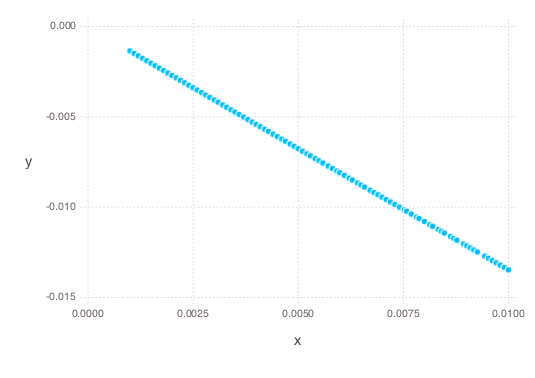

In [21]:
plot(x=dt,y=errfEU)

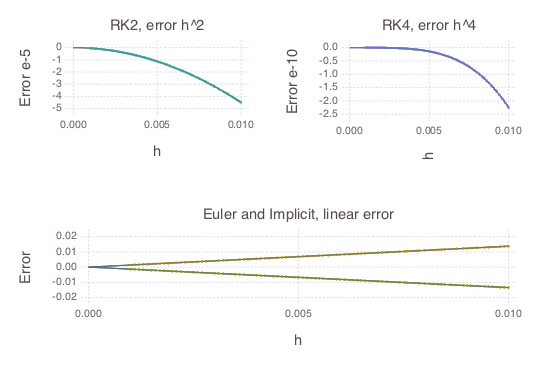

In [32]:
lEU=layer(x=dt,y=errfEU,Geom.point,
Theme(highlight_width=0pt,default_color=green,
default_point_size=1pt))

lIm=layer(x=dt,y=errfIm,Geom.point,
Theme(highlight_width=0pt,default_color=yellow,
default_point_size=1pt))

lRK2=layer(x=dt,y=errfRK2*10^5,Geom.point,
Theme(highlight_width=0pt,default_color=cyan,
default_point_size=1pt))

lRK4=layer(x=dt,y=errfRK4*10^10,Geom.point,
Theme(highlight_width=0pt,default_color=violet,
default_point_size=1pt))

tempEU(x)=(errfEU[end]*x/.01)
tempIm(x)=(errfIm[end]*x/.01)
#le=layer([tempEU,tempIm],0,.01,Geom.line,Theme(default_color=base01))
le=layer(tempEU,0,.01,Geom.line,Theme(default_color=base01))
lei=layer(tempIm,0,.01,Geom.line,Theme(default_color=base01))


temp2(x)=(errfRK2[end]*(x/.01)^2*10^5)
l2=layer(temp2,0,.01,Geom.line,Theme(default_color=base00))

temp4(x)=(errfRK4[end]*(x/.01)^4*10^10)
l4=layer(temp4,0,.01,Geom.line,Theme(default_color=base00))

xl=Guide.xlabel("h")
ylrk2=Guide.ylabel("Error e-5")
ylrk4=Guide.ylabel("Error e-10")
yl=Guide.ylabel("Error")

pEU=plot(lEU,lIm,le,lei,xl,yl,Guide.title("Euler and Implicit, linear error"))
p2=plot(lRK2,l2,xl,ylrk2,Guide.title("RK2, error h^2"))
p4=plot(lRK4,l4,xl,ylrk4,Guide.title("RK4, error h^4"))
vstack(hstack(p2,p4),pEU)

These routines are also present in the M4 folder in a module named `diffeq.jl`. For later work, you may simply import the module.